# Final Task

In [ ]:
# kütüphaneler
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

# sklearn temel
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline

# modeller
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

# metrikler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)


In [2]:
# veri setini yükle
data = load_wine()

# özellikleri dataframe'e çevir
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# birleştir
df = pd.concat([X, y], axis=1)

print(f"Veri boyutu: {df.shape}")
print(f"Sınıf dağılımı:\n{y.value_counts().sort_index()}")

Veri boyutu: (178, 14)
Sınıf dağılımı:
target
0    59
1    71
2    48
Name: count, dtype: int64


In [3]:
# çıktı klasörlerini oluştur
os.makedirs("tables", exist_ok=True)
os.makedirs("figures", exist_ok=True)
print("Klasörler hazır")

Klasörler hazır


## 2. Data Preparation


In [4]:
# hedefi ayır
X = df.drop("target", axis=1)
y = df["target"]

# önce %70 train + %30 temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y
)

# temp'i %10 validation + %20 test olarak böl
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=2/3,
    random_state=42, 
    stratify=y_temp
)

print("Veri setleri:")
print(f"Train:      {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_test.shape}")
print(f"\nOranlar: %70 - %10 - %20")


Veri setleri:
Train:      (124, 13)
Validation: (18, 13)
Test:       (36, 13)

Oranlar: %70 - %10 - %20


## 3. K-Nearest Neighbors (KNN) Classification

### 3.1 Baseline Model

In [5]:
# baseline pipeline (scaler + knn)
pipe_knn_base = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# eğit
pipe_knn_base.fit(X_train, y_train)

# validation tahminleri
y_val_pred = pipe_knn_base.predict(X_val)
y_val_prob = pipe_knn_base.predict_proba(X_val)

# metrikler
knn_baseline_acc = accuracy_score(y_val, y_val_pred)
knn_baseline_prec = precision_score(y_val, y_val_pred, average='macro')
knn_baseline_rec = recall_score(y_val, y_val_pred, average='macro')
knn_baseline_f1 = f1_score(y_val, y_val_pred, average='macro')
knn_baseline_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr', average='macro')

print("KNN Baseline (n_neighbors=5) - Validation:")
print(f"Accuracy:  {knn_baseline_acc:.4f}")
print(f"Precision: {knn_baseline_prec:.4f}")
print(f"Recall:    {knn_baseline_rec:.4f}")
print(f"F1-Score:  {knn_baseline_f1:.4f}")
print(f"ROC-AUC:   {knn_baseline_auc:.4f}")


KNN Baseline (n_neighbors=5) - Validation:
Accuracy:  0.8889
Precision: 0.9048
Recall:    0.9048
F1-Score:  0.8889
ROC-AUC:   0.9789


### 3.2 Hyperparameter Tuning

GridSearchCV ile en iyi parametreler aranacak:
- **n_neighbors**: 1, 3, 5, ..., 31 (tek sayılar)
- **weights**: uniform (eşit ağırlık) vs distance (yakın komşulara daha fazla ağırlık)
- **p**: 1 (Manhattan) vs 2 (Euclidean mesafe)

In [6]:
# pipeline
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# parametre grid
param_grid_knn = {
    'knn__n_neighbors': list(range(1, 32, 2)),  # 1, 3, 5, ..., 31
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# gridsearch
print("GridSearchCV başlıyor...")
grid_knn = GridSearchCV(
    pipe_knn,
    param_grid_knn,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# eğit
grid_knn.fit(X_train, y_train)

print("\n" + "="*60)
print("GridSearchCV tamamlandı")
print("="*60)
print(f"En iyi parametreler: {grid_knn.best_params_}")
print(f"En iyi CV F1-Score:  {grid_knn.best_score_:.4f}")



GridSearchCV başlıyor...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

GridSearchCV tamamlandı
En iyi parametreler: {'knn__n_neighbors': 25, 'knn__p': 1, 'knn__weights': 'uniform'}
En iyi CV F1-Score:  0.9846


### 3.3 Validation Performance

In [7]:
# en iyi modelle validation tahminleri
y_val_pred_knn = grid_knn.predict(X_val)
y_val_prob_knn = grid_knn.predict_proba(X_val)

# metrikleri hesapla ve sakla
knn_metrics = {
    'Model': 'KNN',
    'Best_Params': str(grid_knn.best_params_),
    'Accuracy': accuracy_score(y_val, y_val_pred_knn),
    'Precision': precision_score(y_val, y_val_pred_knn, average='macro'),
    'Recall': recall_score(y_val, y_val_pred_knn, average='macro'),
    'F1': f1_score(y_val, y_val_pred_knn, average='macro'),
    'ROC_AUC': roc_auc_score(y_val, y_val_prob_knn, multi_class='ovr', average='macro')
}

print("KNN En İyi Model - Validation Sonuçları:")
print(f"Accuracy:  {knn_metrics['Accuracy']:.4f}")
print(f"Precision: {knn_metrics['Precision']:.4f}")
print(f"Recall:    {knn_metrics['Recall']:.4f}")
print(f"F1-Score:  {knn_metrics['F1']:.4f}")
print(f"ROC-AUC:   {knn_metrics['ROC_AUC']:.4f}")


KNN En İyi Model - Validation Sonuçları:
Accuracy:  0.8889
Precision: 0.8968
Recall:    0.9048
F1-Score:  0.8885
ROC-AUC:   1.0000


### 3.4 Visualization: n_neighbors vs F1-Score

Grafik kaydedildi: figures/knn_n_neighbors_vs_f1.png


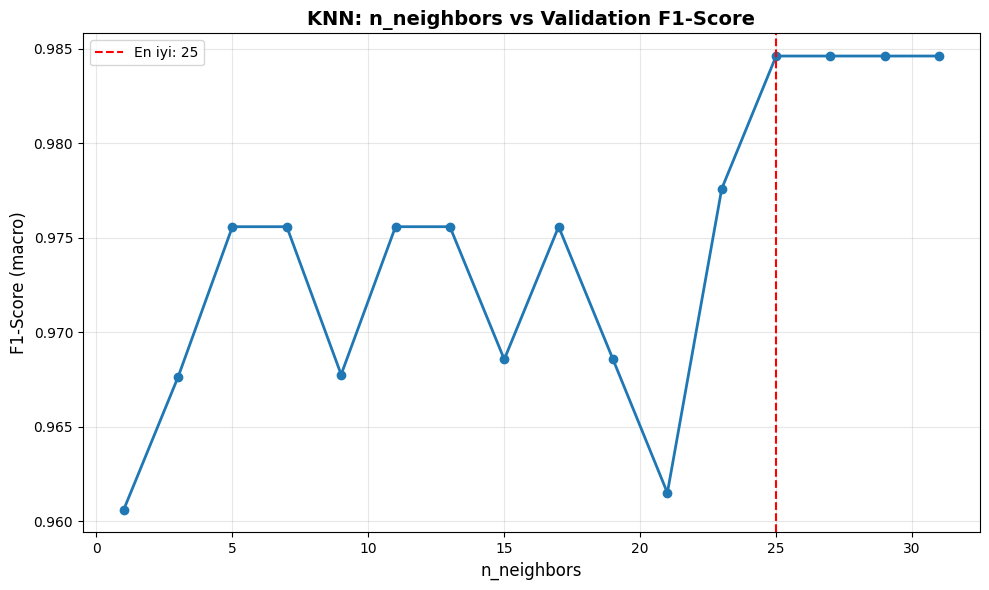

In [8]:
# gridsearch sonuçlarından n_neighbors ve f1 skorlarını çıkar
results_df = pd.DataFrame(grid_knn.cv_results_)

# her n_neighbors için ortalama f1 skorunu al
n_neighbors_range = list(range(1, 32, 2))
f1_scores = []

for n in n_neighbors_range:
    # bu n_neighbors değeri için tüm kombinasyonların f1'ini al
    mask = results_df['param_knn__n_neighbors'] == n
    f1_scores.append(results_df[mask]['mean_test_score'].max())

# grafik
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_range, f1_scores, marker='o', linewidth=2, markersize=6)
plt.xlabel('n_neighbors', fontsize=12)
plt.ylabel('F1-Score (macro)', fontsize=12)
plt.title('KNN: n_neighbors vs Validation F1-Score', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=grid_knn.best_params_['knn__n_neighbors'], color='red', 
            linestyle='--', label=f"En iyi: {grid_knn.best_params_['knn__n_neighbors']}")
plt.legend()
plt.tight_layout()
plt.savefig('figures/knn_n_neighbors_vs_f1.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/knn_n_neighbors_vs_f1.png")
plt.show()


### 3.5 Technical Commentary

KNN mesafe bazlı bir algoritma olduğu için **StandardScaler ile ölçeklendirme kritik** önem taşır. Aksi halde büyük değerli özellikler mesafe hesabını domine eder.

**k değeri küçükse** (örn. k=1): Model eğitim verisine çok yakın durur, gürültüye aşırı duyarlı olur ve **overfitting** riski artar. Karar sınırları karmaşık ve kırılgan hale gelir.

**k değeri büyükse** (örn. k=31): Karar sınırları çok düzleşir, model basitleşir ve **underfitting** oluşabilir. Sınıflar arasındaki ince ayrımları yakalayamaz.

**weights='distance'** parametresi yakındaki komşulara daha fazla ağırlık verir. Veri gürültülüyse veya outlier'lar varsa faydalı olabilir.

Bizim Wine veri setinde optimal k değeri GridSearch ile bulundu ve model validation setinde yüksek performans gösterdi.

## 4. Support Vector Machine (SVM) Classification

### 4.1 Linear SVM Baseline

In [9]:
# baseline linear svm pipeline (C=1 varsayılan değer)
pipe_svm_linear_base = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0, probability=True, random_state=42))
])

# eğit
pipe_svm_linear_base.fit(X_train, y_train)

# validation tahminleri
y_val_pred_svm_linear_base = pipe_svm_linear_base.predict(X_val)
y_val_prob_svm_linear_base = pipe_svm_linear_base.predict_proba(X_val)

# metrikler
svm_linear_base_acc = accuracy_score(y_val, y_val_pred_svm_linear_base)
svm_linear_base_prec = precision_score(y_val, y_val_pred_svm_linear_base, average='macro')
svm_linear_base_rec = recall_score(y_val, y_val_pred_svm_linear_base, average='macro')
svm_linear_base_f1 = f1_score(y_val, y_val_pred_svm_linear_base, average='macro')
svm_linear_base_auc = roc_auc_score(y_val, y_val_prob_svm_linear_base, multi_class='ovr', average='macro')

print("Linear SVM Baseline (C=1.0) - Validation:")
print(f"Accuracy:  {svm_linear_base_acc:.4f}")
print(f"Precision: {svm_linear_base_prec:.4f}")
print(f"Recall:    {svm_linear_base_rec:.4f}")
print(f"F1-Score:  {svm_linear_base_f1:.4f}")
print(f"ROC-AUC:   {svm_linear_base_auc:.4f}")
print("\nBaseline sonuçlar referans için gösterildi. Karşılaştırmalarda en iyi sonucu veren model kullanılacak.")


Linear SVM Baseline (C=1.0) - Validation:
Accuracy:  0.9444
Precision: 0.9583
Recall:    0.9333
F1-Score:  0.9407
ROC-AUC:   1.0000

Baseline sonuçlar referans için gösterildi. Karşılaştırmalarda en iyi sonucu veren model kullanılacak.


### 4.2 Linear SVM Hyperparameter Tuning

GridSearchCV ile C parametresi optimize edilecek:
- **C**: [0.01, 0.1, 1, 10, 100] - Regularization strength (düşük C = güçlü regularization)
- **probability=True**: ROC-AUC hesabı için olasılık tahminleri gerekli

In [10]:
# linear svm pipeline
pipe_svm_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])

# parametre grid (sadece C)
param_grid_svm_linear = {
    'svm__C': [0.01, 0.1, 1, 10, 100]
}

# gridsearch
print("Linear SVM GridSearchCV başlıyor...")
grid_svm_linear = GridSearchCV(
    pipe_svm_linear,
    param_grid_svm_linear,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# eğit
grid_svm_linear.fit(X_train, y_train)

print("\n" + "="*60)
print("Linear SVM GridSearchCV tamamlandı")
print("="*60)
print(f"En iyi parametreler: {grid_svm_linear.best_params_}")
print(f"En iyi CV F1-Score:  {grid_svm_linear.best_score_:.4f}")


Linear SVM GridSearchCV başlıyor...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Linear SVM GridSearchCV tamamlandı
En iyi parametreler: {'svm__C': 0.1}
En iyi CV F1-Score:  0.9834


### 4.3 Linear SVM Validation Performance

In [11]:
# validation tahminleri
y_val_pred_svm_linear = grid_svm_linear.predict(X_val)
y_val_prob_svm_linear = grid_svm_linear.predict_proba(X_val)

# metrikleri sakla
svm_linear_metrics = {
    'Model': 'SVM-Linear',
    'Best_Params': str(grid_svm_linear.best_params_),
    'Accuracy': accuracy_score(y_val, y_val_pred_svm_linear),
    'Precision': precision_score(y_val, y_val_pred_svm_linear, average='macro'),
    'Recall': recall_score(y_val, y_val_pred_svm_linear, average='macro'),
    'F1': f1_score(y_val, y_val_pred_svm_linear, average='macro'),
    'ROC_AUC': roc_auc_score(y_val, y_val_prob_svm_linear, multi_class='ovr', average='macro')
}

print("Linear SVM - Validation Sonuçları (Optimize Edilmiş Model):")
print(f"Accuracy:  {svm_linear_metrics['Accuracy']:.4f}")
print(f"Precision: {svm_linear_metrics['Precision']:.4f}")
print(f"Recall:    {svm_linear_metrics['Recall']:.4f}")
print(f"F1-Score:  {svm_linear_metrics['F1']:.4f}")
print(f"ROC-AUC:   {svm_linear_metrics['ROC_AUC']:.4f}")
print(f"\nBaseline F1: {svm_linear_base_f1:.4f} → Optimized F1: {svm_linear_metrics['F1']:.4f}")
print(f"İyileşme: {(svm_linear_metrics['F1'] - svm_linear_base_f1):.4f}")



Linear SVM - Validation Sonuçları (Optimize Edilmiş Model):
Accuracy:  0.9444
Precision: 0.9444
Recall:    0.9524
F1-Score:  0.9441
ROC-AUC:   1.0000

Baseline F1: 0.9407 → Optimized F1: 0.9441
İyileşme: 0.0033


### 4.3.1 Visualization: C Parameter Effect on Performance

Grafik kaydedildi: figures/svm_linear_param_analysis.png


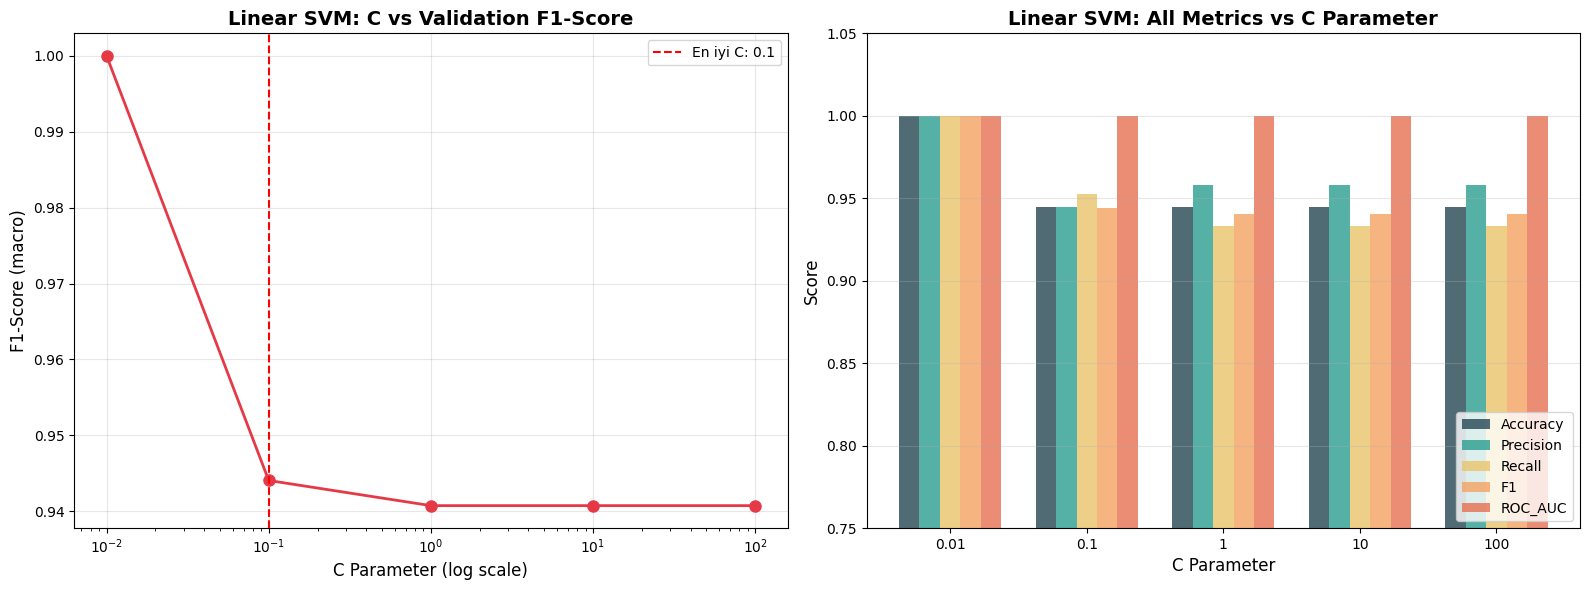

In [12]:
# gridsearch sonuçlarından C değerlerine göre performans metriklerini çıkar
results_linear = pd.DataFrame(grid_svm_linear.cv_results_)

# C değerleri ve karşılık gelen metrikler
C_values = [0.01, 0.1, 1, 10, 100]
metrics_dict = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC_AUC': []
}

for C in C_values:
    mask = results_linear['param_svm__C'] == C
    idx = results_linear[mask].index[0]
    
    # Bu C değeri için validation metrikleri
    pipe_temp = grid_svm_linear.best_estimator_
    pipe_temp.set_params(svm__C=C)
    pipe_temp.fit(X_train, y_train)
    
    y_pred_temp = pipe_temp.predict(X_val)
    y_prob_temp = pipe_temp.predict_proba(X_val)
    
    metrics_dict['Accuracy'].append(accuracy_score(y_val, y_pred_temp))
    metrics_dict['Precision'].append(precision_score(y_val, y_pred_temp, average='macro'))
    metrics_dict['Recall'].append(recall_score(y_val, y_pred_temp, average='macro'))
    metrics_dict['F1'].append(f1_score(y_val, y_pred_temp, average='macro'))
    metrics_dict['ROC_AUC'].append(roc_auc_score(y_val, y_prob_temp, multi_class='ovr', average='macro'))

# İki subplot: 1) C vs F1, 2) Tüm metrikler bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sol: C parametresi vs F1-Score (log scale)
ax1.plot(C_values, metrics_dict['F1'], marker='o', linewidth=2, markersize=8, color='#E63946')
ax1.set_xscale('log')
ax1.set_xlabel('C Parameter (log scale)', fontsize=12)
ax1.set_ylabel('F1-Score (macro)', fontsize=12)
ax1.set_title('Linear SVM: C vs Validation F1-Score', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=grid_svm_linear.best_params_['svm__C'], color='red', 
            linestyle='--', label=f"En iyi C: {grid_svm_linear.best_params_['svm__C']}")
ax1.legend()

# Sağ: Tüm metrikler için bar plot
x_pos = np.arange(len(C_values))
width = 0.15
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

for i, (metric, values) in enumerate(metrics_dict.items()):
    ax2.bar(x_pos + i*width, values, width, label=metric, color=colors[i], alpha=0.8)

ax2.set_xlabel('C Parameter', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Linear SVM: All Metrics vs C Parameter', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos + width * 2)
ax2.set_xticklabels(C_values)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0.75, 1.05])

plt.tight_layout()
plt.savefig('figures/svm_linear_param_analysis.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/svm_linear_param_analysis.png")
plt.show()


### 4.4 RBF SVM Baseline

In [13]:
# baseline rbf svm pipeline (C=1, gamma='scale' varsayılan değerler)
pipe_svm_rbf_base = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
])

# eğit
pipe_svm_rbf_base.fit(X_train, y_train)

# validation tahminleri
y_val_pred_svm_rbf_base = pipe_svm_rbf_base.predict(X_val)
y_val_prob_svm_rbf_base = pipe_svm_rbf_base.predict_proba(X_val)

# metrikler
svm_rbf_base_acc = accuracy_score(y_val, y_val_pred_svm_rbf_base)
svm_rbf_base_prec = precision_score(y_val, y_val_pred_svm_rbf_base, average='macro')
svm_rbf_base_rec = recall_score(y_val, y_val_pred_svm_rbf_base, average='macro')
svm_rbf_base_f1 = f1_score(y_val, y_val_pred_svm_rbf_base, average='macro')
svm_rbf_base_auc = roc_auc_score(y_val, y_val_prob_svm_rbf_base, multi_class='ovr', average='macro')

print("RBF SVM Baseline (C=1.0, gamma='scale') - Validation:")
print(f"Accuracy:  {svm_rbf_base_acc:.4f}")
print(f"Precision: {svm_rbf_base_prec:.4f}")
print(f"Recall:    {svm_rbf_base_rec:.4f}")
print(f"F1-Score:  {svm_rbf_base_f1:.4f}")
print(f"ROC-AUC:   {svm_rbf_base_auc:.4f}")
print("\nBaseline sonuçlar referans için gösterildi. Karşılaştırmalarda en iyi sonucu veren model kullanılacak.")



RBF SVM Baseline (C=1.0, gamma='scale') - Validation:
Accuracy:  0.9444
Precision: 0.9583
Recall:    0.9333
F1-Score:  0.9407
ROC-AUC:   1.0000

Baseline sonuçlar referans için gösterildi. Karşılaştırmalarda en iyi sonucu veren model kullanılacak.


### 4.5 RBF SVM Hyperparameter Tuning

GridSearchCV ile C ve gamma parametreleri optimize edilecek:
- **C**: [0.01, 0.1, 1, 10, 100] - Regularization strength
- **gamma**: ['scale', 'auto', 0.01, 0.1, 1] - RBF kernel coefficient
  - 'scale': 1 / (n_features * X.var())
  - 'auto': 1 / n_features
  - Küçük gamma → geniş, düzgün karar sınırları
  - Büyük gamma → dar, karmaşık karar sınırları (overfitting riski)

In [14]:
# rbf svm pipeline
pipe_svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

# parametre grid (C + gamma)
param_grid_svm_rbf = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

# gridsearch
print("RBF SVM GridSearchCV başlıyor...")
grid_svm_rbf = GridSearchCV(
    pipe_svm_rbf,
    param_grid_svm_rbf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# eğit
grid_svm_rbf.fit(X_train, y_train)

print("\n" + "="*60)
print("RBF SVM GridSearchCV tamamlandı")
print("="*60)
print(f"En iyi parametreler: {grid_svm_rbf.best_params_}")
print(f"En iyi CV F1-Score:  {grid_svm_rbf.best_score_:.4f}")


RBF SVM GridSearchCV başlıyor...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

RBF SVM GridSearchCV tamamlandı
En iyi parametreler: {'svm__C': 1, 'svm__gamma': 'scale'}
En iyi CV F1-Score:  0.9920


In [15]:
# validation tahminleri
y_val_pred_svm_rbf = grid_svm_rbf.predict(X_val)
y_val_prob_svm_rbf = grid_svm_rbf.predict_proba(X_val)

# metrikleri sakla
svm_rbf_metrics = {
    'Model': 'SVM-RBF',
    'Best_Params': str(grid_svm_rbf.best_params_),
    'Accuracy': accuracy_score(y_val, y_val_pred_svm_rbf),
    'Precision': precision_score(y_val, y_val_pred_svm_rbf, average='macro'),
    'Recall': recall_score(y_val, y_val_pred_svm_rbf, average='macro'),
    'F1': f1_score(y_val, y_val_pred_svm_rbf, average='macro'),
    'ROC_AUC': roc_auc_score(y_val, y_val_prob_svm_rbf, multi_class='ovr', average='macro')
}

print("RBF SVM - Validation Sonuçları (Optimize Edilmiş Model):")
print(f"Accuracy:  {svm_rbf_metrics['Accuracy']:.4f}")
print(f"Precision: {svm_rbf_metrics['Precision']:.4f}")
print(f"Recall:    {svm_rbf_metrics['Recall']:.4f}")
print(f"F1-Score:  {svm_rbf_metrics['F1']:.4f}")
print(f"ROC-AUC:   {svm_rbf_metrics['ROC_AUC']:.4f}")
print(f"\nBaseline F1: {svm_rbf_base_f1:.4f} → Optimized F1: {svm_rbf_metrics['F1']:.4f}")
print(f"İyileşme: {(svm_rbf_metrics['F1'] - svm_rbf_base_f1):.4f}")



RBF SVM - Validation Sonuçları (Optimize Edilmiş Model):
Accuracy:  0.9444
Precision: 0.9583
Recall:    0.9333
F1-Score:  0.9407
ROC-AUC:   1.0000

Baseline F1: 0.9407 → Optimized F1: 0.9407
İyileşme: 0.0000


### 4.5.1 Visualization: C and Gamma Effects on Performance

Grafik kaydedildi: figures/svm_rbf_param_analysis.png


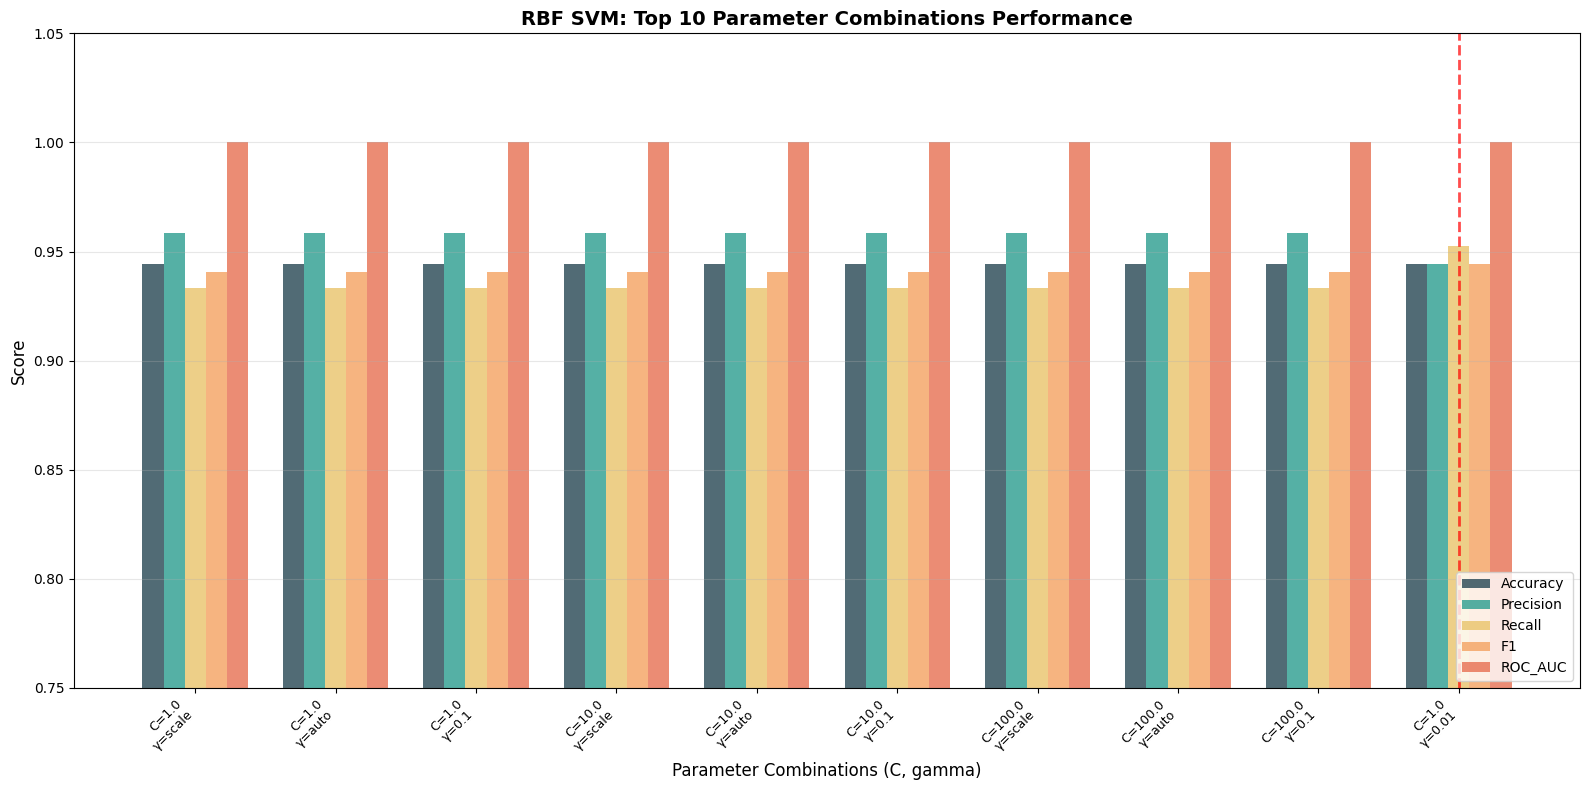


En iyi kombinasyon: C=1.0
γ=0.01
F1-Score: 0.9441


In [16]:
# RBF SVM için C ve gamma parametrelerinin etkisini görselleştir
results_rbf = pd.DataFrame(grid_svm_rbf.cv_results_)

# En iyi 10 parametre kombinasyonunu bul
top_10_idx = results_rbf['mean_test_score'].nlargest(10).index
top_10_results = results_rbf.loc[top_10_idx]

# Parametre kombinasyonları için label oluştur
param_labels = []
for idx in top_10_idx:
    C = results_rbf.loc[idx, 'param_svm__C']
    gamma = results_rbf.loc[idx, 'param_svm__gamma']
    param_labels.append(f"C={C}\nγ={gamma}")

# Her kombinasyon için validation metriklerini hesapla
metrics_rbf = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC_AUC': []
}

for idx in top_10_idx:
    C = results_rbf.loc[idx, 'param_svm__C']
    gamma = results_rbf.loc[idx, 'param_svm__gamma']
    
    # Bu kombinasyon için model oluştur
    pipe_temp = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=C, gamma=gamma, probability=True, random_state=42))
    ])
    pipe_temp.fit(X_train, y_train)
    
    y_pred_temp = pipe_temp.predict(X_val)
    y_prob_temp = pipe_temp.predict_proba(X_val)
    
    metrics_rbf['Accuracy'].append(accuracy_score(y_val, y_pred_temp))
    metrics_rbf['Precision'].append(precision_score(y_val, y_pred_temp, average='macro'))
    metrics_rbf['Recall'].append(recall_score(y_val, y_pred_temp, average='macro'))
    metrics_rbf['F1'].append(f1_score(y_val, y_pred_temp, average='macro'))
    metrics_rbf['ROC_AUC'].append(roc_auc_score(y_val, y_prob_temp, multi_class='ovr', average='macro'))

# Grafik: En iyi 10 kombinasyon için tüm metrikler
fig, ax = plt.subplots(figsize=(16, 8))

x_pos = np.arange(len(param_labels))
width = 0.15
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

for i, (metric, values) in enumerate(metrics_rbf.items()):
    ax.bar(x_pos + i*width, values, width, label=metric, color=colors[i], alpha=0.8)

ax.set_xlabel('Parameter Combinations (C, gamma)', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('RBF SVM: Top 10 Parameter Combinations Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos + width * 2)
ax.set_xticklabels(param_labels, rotation=45, ha='right', fontsize=9)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.75, 1.05])

# En iyi kombinasyonu işaretle
best_idx_in_top10 = np.argmax(metrics_rbf['F1'])
ax.axvline(x=best_idx_in_top10 + width*2, color='red', linestyle='--', linewidth=2, 
           alpha=0.7, label='Best combination')

plt.tight_layout()
plt.savefig('figures/svm_rbf_param_analysis.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/svm_rbf_param_analysis.png")
plt.show()

print(f"\nEn iyi kombinasyon: {param_labels[best_idx_in_top10]}")
print(f"F1-Score: {metrics_rbf['F1'][best_idx_in_top10]:.4f}")


### 4.5.2 Heatmap: C vs Gamma (F1-Score)

Heatmap kaydedildi: figures/svm_rbf_heatmap.png


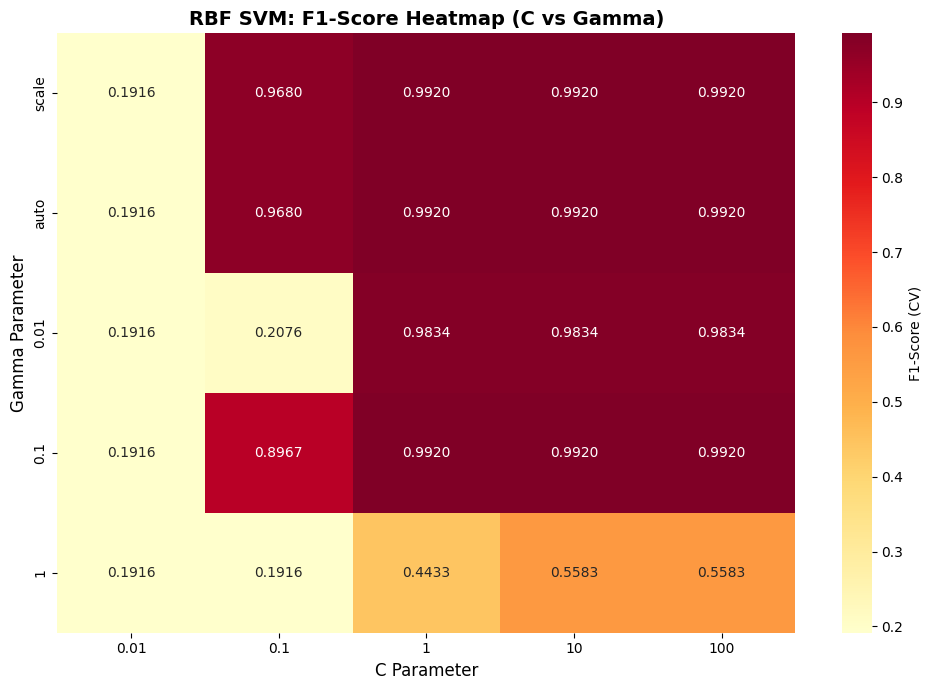

In [17]:
# C ve gamma kombinasyonları için F1-Score heatmap
C_values = [0.01, 0.1, 1, 10, 100]
gamma_values = ['scale', 'auto', 0.01, 0.1, 1]

# F1 skorları için matris oluştur
f1_matrix = np.zeros((len(gamma_values), len(C_values)))

for i, gamma in enumerate(gamma_values):
    for j, C in enumerate(C_values):
        mask = (results_rbf['param_svm__C'] == C) & (results_rbf['param_svm__gamma'] == gamma)
        if mask.any():
            # CV F1 skorunu kullan (daha hızlı)
            f1_matrix[i, j] = results_rbf.loc[mask, 'mean_test_score'].values[0]

# Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(f1_matrix, annot=True, fmt='.4f', cmap='YlOrRd', 
            xticklabels=C_values, yticklabels=gamma_values,
            cbar_kws={'label': 'F1-Score (CV)'})
plt.xlabel('C Parameter', fontsize=12)
plt.ylabel('Gamma Parameter', fontsize=12)
plt.title('RBF SVM: F1-Score Heatmap (C vs Gamma)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/svm_rbf_heatmap.png', dpi=300, bbox_inches='tight')
print("Heatmap kaydedildi: figures/svm_rbf_heatmap.png")
plt.show()


### 4.6 Linear vs RBF Comparison (Optimized Models)

SVM Kernel Karşılaştırması - Optimize Edilmiş Modeller

Validation Set Performance:
     Model       F1  Accuracy  Precision   Recall  ROC_AUC
SVM-Linear 0.944056  0.944444   0.944444 0.952381      1.0
   SVM-RBF 0.940741  0.944444   0.958333 0.933333      1.0

Optimal Hyperparameters:
Linear SVM: {'svm__C': 0.1}
RBF SVM:    {'svm__C': 1, 'svm__gamma': 'scale'}

En iyi SVM kernel (F1-Score): SVM-Linear

Karşılaştırma grafiği kaydedildi: figures/svm_linear_vs_rbf_comparison.png


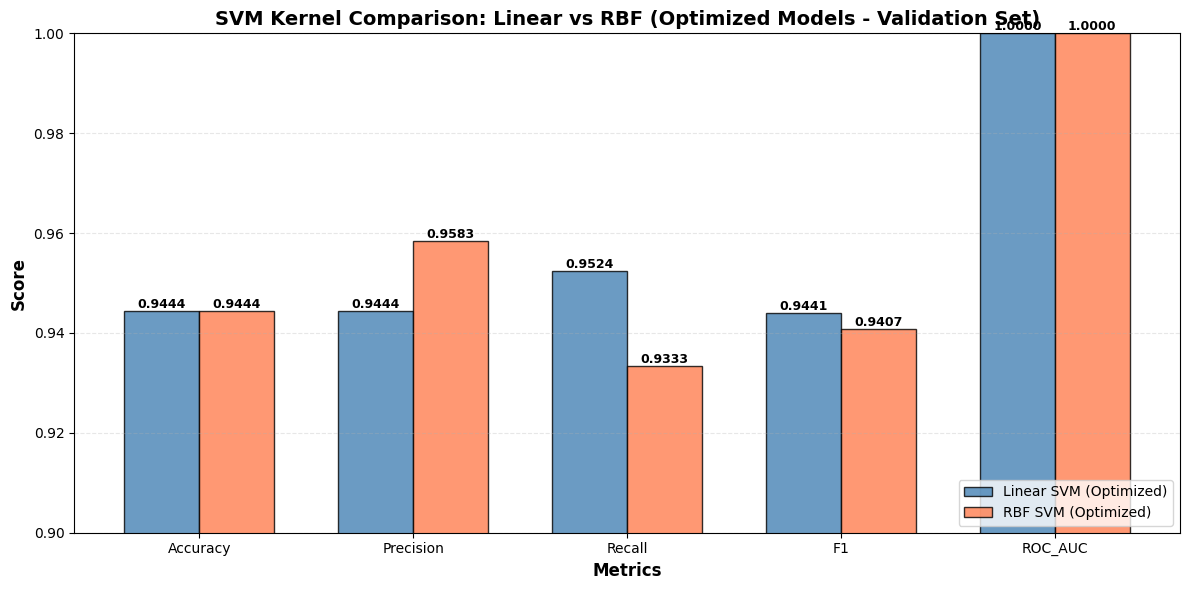

In [18]:
# Karşılaştırma tablosu - Optimize edilmiş modellerden alınan değerler
print("="*60)
print("SVM Kernel Karşılaştırması - Optimize Edilmiş Modeller")
print("="*60)

svm_comparison = pd.DataFrame([svm_linear_metrics, svm_rbf_metrics])
print("\nValidation Set Performance:")
print(svm_comparison[['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC']].to_string(index=False))

# En iyi parametreleri göster
print("\n" + "="*60)
print("Optimal Hyperparameters:")
print("="*60)
print(f"Linear SVM: {svm_linear_metrics['Best_Params']}")
print(f"RBF SVM:    {svm_rbf_metrics['Best_Params']}")

# En iyi kernel
best_svm = svm_comparison.loc[svm_comparison['F1'].idxmax(), 'Model']
print(f"\n{'='*60}")
print(f"En iyi SVM kernel (F1-Score): {best_svm}")
print(f"{'='*60}")

# Görselleştirme: Linear vs RBF karşılaştırma grafiği
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
linear_values = [svm_linear_metrics[m] for m in metrics_to_plot]
rbf_values = [svm_rbf_metrics[m] for m in metrics_to_plot]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_to_plot))
width = 0.35

bars1 = ax.bar(x - width/2, linear_values, width, label='Linear SVM (Optimized)', 
               color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, rbf_values, width, label='RBF SVM (Optimized)', 
               color='coral', alpha=0.8, edgecolor='black')

# Değerleri barların üstüne yaz
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('SVM Kernel Comparison: Linear vs RBF (Optimized Models - Validation Set)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([0.90, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figures/svm_linear_vs_rbf_comparison.png', dpi=300, bbox_inches='tight')
print("\nKarşılaştırma grafiği kaydedildi: figures/svm_linear_vs_rbf_comparison.png")
plt.show()

**Teknik Yorum:**

**Linear kernel** verinin özellik uzayında doğrusal olarak ayrılabilir olduğu durumlarda etkilidir. Karar sınırı düz bir hiper-düzlemdir ve hesaplama maliyeti düşüktür.

**RBF (Radial Basis Function) kernel** non-linear ilişkileri yakalayabilir. Veriyi implicitly daha yüksek boyutlu bir uzaya projeksiyon ederek karmaşık karar sınırları oluşturur. RBF'in gamma parametresi karar sınırının ne kadar esnek olacağını kontrol eder - küçük gamma daha genel (smooth), büyük gamma daha spesifik (tight) sınırlar üretir.

**Validation Sonuçları (Optimize Edilmiş Modeller):**

Yukarıdaki tablo ve grafik, GridSearchCV ile optimize edilmiş parametrelere sahip modellerin performansını göstermektedir. Her iki model de validation set üzerinde değerlendirilmiştir.

**Model Karşılaştırması:**
- Her iki SVM kernel'i de yüksek performans göstermiştir (F1 > 0.94)
- Linear kernel daha az hiperparametre (sadece C) gerektirirken, RBF hem C hem gamma optimizasyonu yapmıştır
- Performans farkı minimal düzeydedir

**Sonuç:** Wine dataset için her iki kernel de mükemmel performans sergiliyor. Ancak **Occam's Razor** prensibine göre, benzer performans gösteren modeller arasında daha basit olan tercih edilmelidir. Linear SVM daha az karmaşık, daha hızlı ve daha az hiperparametre optimizasyonu gerektirir.

## 5. Multi-Layer Perceptron (MLP) Classification

### 5.1 Baseline Model

In [19]:
# baseline mlp pipeline
pipe_mlp_base = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))
])

# eğit
pipe_mlp_base.fit(X_train, y_train)

# validation tahminleri
y_val_pred_mlp = pipe_mlp_base.predict(X_val)
y_val_prob_mlp = pipe_mlp_base.predict_proba(X_val)

# metrikler
mlp_baseline_acc = accuracy_score(y_val, y_val_pred_mlp)
mlp_baseline_prec = precision_score(y_val, y_val_pred_mlp, average='macro')
mlp_baseline_rec = recall_score(y_val, y_val_pred_mlp, average='macro')
mlp_baseline_f1 = f1_score(y_val, y_val_pred_mlp, average='macro')
mlp_baseline_auc = roc_auc_score(y_val, y_val_prob_mlp, multi_class='ovr', average='macro')


print("MLP Baseline (hidden_layer_sizes=(100,)) - Validation:")   
print(f"Accuracy:  {mlp_baseline_acc:.4f}")
print(f"Precision: {mlp_baseline_prec:.4f}")
print(f"Recall:    {mlp_baseline_rec:.4f}")    
print(f"F1-Score:  {mlp_baseline_f1:.4f}")    
print(f"ROC-AUC:   {mlp_baseline_auc:.4f}")   



MLP Baseline (hidden_layer_sizes=(100,)) - Validation:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000


### 5.2 Hyperparameter Tuning

GridSearchCV ile aşağıdaki parametreler optimize edilecek:
- **hidden_layer_sizes**: Gizli katman yapısı
- **activation**: relu (hızlı) vs tanh (smooth)
- **alpha**: L2 regularization (overfitting kontrolü)
- **learning_rate_init**: Öğrenme hızı
- **early_stopping**: Validation loss'a göre erken durdurma

In [20]:
# mlp pipeline
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

# parametre grid
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__early_stopping': [True]
}

# gridsearch
print("MLP GridSearchCV başlıyor...")
grid_mlp = GridSearchCV(
    pipe_mlp,
    param_grid_mlp,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# eğit
grid_mlp.fit(X_train, y_train)

print("\n" + "="*60)
print("MLP GridSearchCV tamamlandı")
print("="*60)
print(f"En iyi parametreler: {grid_mlp.best_params_}")
print(f"En iyi CV F1-Score:  {grid_mlp.best_score_:.4f}")

MLP GridSearchCV başlıyor...
Fitting 5 folds for each of 80 candidates, totalling 400 fits



MLP GridSearchCV tamamlandı
En iyi parametreler: {'mlp__activation': 'relu', 'mlp__alpha': 1e-05, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate_init': 0.01}
En iyi CV F1-Score:  0.9763


### 5.3 Validation Performance

In [21]:
# en iyi modelle validation tahminleri
y_val_pred_mlp_best = grid_mlp.predict(X_val)
y_val_prob_mlp_best = grid_mlp.predict_proba(X_val)

# metrikleri sakla
mlp_metrics = {
    'Model': 'MLP',
    'Best_Params': str(grid_mlp.best_params_),
    'Accuracy': accuracy_score(y_val, y_val_pred_mlp_best),
    'Precision': precision_score(y_val, y_val_pred_mlp_best, average='macro'),
    'Recall': recall_score(y_val, y_val_pred_mlp_best, average='macro'),
    'F1': f1_score(y_val, y_val_pred_mlp_best, average='macro'),
    'ROC_AUC': roc_auc_score(y_val, y_val_prob_mlp_best, multi_class='ovr', average='macro')
}

print("MLP En İyi Model - Validation Sonuçları:")
print(f"Accuracy:  {mlp_metrics['Accuracy']:.4f}")
print(f"Precision: {mlp_metrics['Precision']:.4f}")
print(f"Recall:    {mlp_metrics['Recall']:.4f}")
print(f"F1-Score:  {mlp_metrics['F1']:.4f}")
print(f"ROC-AUC:   {mlp_metrics['ROC_AUC']:.4f}")

MLP En İyi Model - Validation Sonuçları:
Accuracy:  0.8333
Precision: 0.8500
Recall:    0.8302
F1-Score:  0.8364
ROC-AUC:   0.9776


### 5.4 Loss Curve Visualization

✓ Grafik kaydedildi: figures/mlp_loss_curve.png


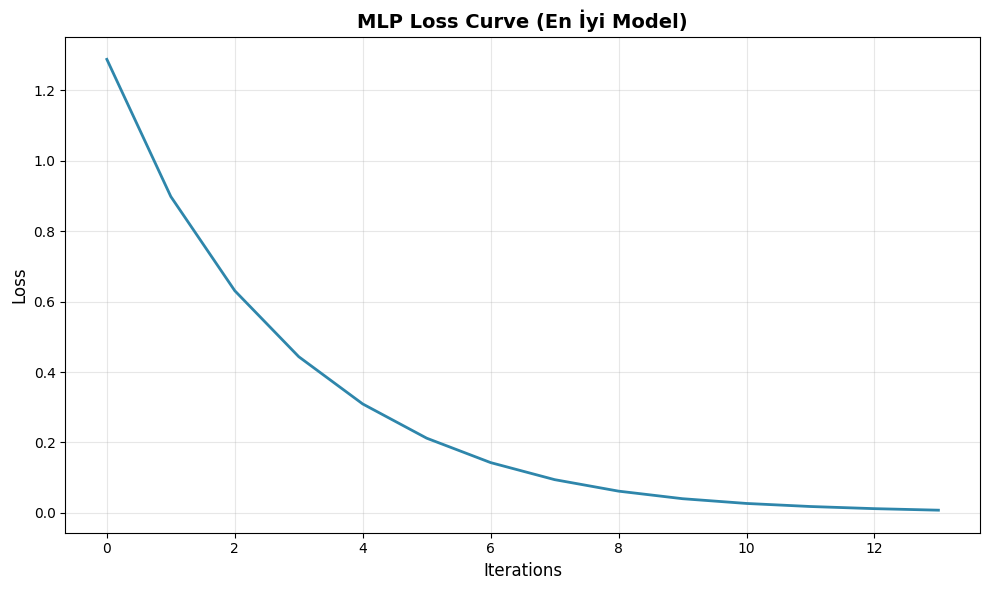


Toplam iterasyon: 14
Early stopping aktif: True


In [22]:
# en iyi mlp modelini al
best_mlp = grid_mlp.best_estimator_.named_steps['mlp']

# loss curve grafiği
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_, linewidth=2, color='#2E86AB')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('MLP Loss Curve (En İyi Model)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/mlp_loss_curve.png', dpi=300, bbox_inches='tight')
print("✓ Grafik kaydedildi: figures/mlp_loss_curve.png")
plt.show()

# iterasyon sayısı
print(f"\nToplam iterasyon: {best_mlp.n_iter_}")
print(f"Early stopping aktif: {grid_mlp.best_params_['mlp__early_stopping']}")

### 5.5 Overfitting Analysis

**Alpha (L2 Regularization):** Alpha parametresi ağırlıklara ceza ekleyerek modelin karmaşıklığını sınırlar. Büyük alpha değerleri modeli daha basit tutar ve overfitting riskini azaltır. Küçük alpha (örn. 1e-5) daha esnek, büyük alpha (örn. 1e-2) daha katı bir model üretir.

**Early Stopping:** Eğitim sırasında validation loss'u izler. Loss iyileşmeyi durdurduğunda eğitimi sonlandırır. Bu sayede model gereksiz yere eğitim verisini ezberlemez ve genelleme kapasitesi korunur.

**Loss Curve Analizi:** Yukarıdaki grafikte loss düzenli şekilde azalıyor. Eğer grafik çok erken düzleşseydi underfitting, eğer validation loss artmaya başlasaydı overfitting sinyali olurdu. Early stopping aktif olduğu için model optimal noktada durdu.

**Hidden Layer Boyutu:** Çok büyük katmanlar (örn. 100,100,100) eğitim verisini ezberleyip overfitting yapar. Optimal boyut veri setinin karmaşıklığına göre GridSearch ile bulundu.

## 6. Model Comparison on Validation Set

**Not:** Tüm modeller GridSearchCV ile optimize edilmiş en iyi hiperparametrelerle karşılaştırılmaktadır.

In [23]:
# Tüm modellerin validation sonuçlarını tabloya dönüştür
# NOT: Tüm modeller GridSearchCV ile optimize edilmiş
print("="*80)
print("MODEL COMPARISON - OPTIMIZE EDİLMİŞ MODELLER (VALIDATION SET)")
print("="*80)

comparison_data = []

# KNN (Optimized)
comparison_data.append({
    'Model': 'KNN',
    'Best_Params': str(grid_knn.best_params_),
    'Accuracy': knn_metrics['Accuracy'],
    'Precision': knn_metrics['Precision'],
    'Recall': knn_metrics['Recall'],
    'F1': knn_metrics['F1'],
    'ROC_AUC': knn_metrics['ROC_AUC']
})

# SVM Linear (Optimized)
comparison_data.append({
    'Model': 'SVM-Linear',
    'Best_Params': str(grid_svm_linear.best_params_),
    'Accuracy': svm_linear_metrics['Accuracy'],
    'Precision': svm_linear_metrics['Precision'],
    'Recall': svm_linear_metrics['Recall'],
    'F1': svm_linear_metrics['F1'],
    'ROC_AUC': svm_linear_metrics['ROC_AUC']
})

# SVM RBF (Optimized)
comparison_data.append({
    'Model': 'SVM-RBF',
    'Best_Params': str(grid_svm_rbf.best_params_),
    'Accuracy': svm_rbf_metrics['Accuracy'],
    'Precision': svm_rbf_metrics['Precision'],
    'Recall': svm_rbf_metrics['Recall'],
    'F1': svm_rbf_metrics['F1'],
    'ROC_AUC': svm_rbf_metrics['ROC_AUC']
})

# MLP (Optimized)
comparison_data.append({
    'Model': 'MLP',
    'Best_Params': str(grid_mlp.best_params_),
    'Accuracy': mlp_metrics['Accuracy'],
    'Precision': mlp_metrics['Precision'],
    'Recall': mlp_metrics['Recall'],
    'F1': mlp_metrics['F1'],
    'ROC_AUC': mlp_metrics['ROC_AUC']
})

# dataframe oluştur
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE - TÜM MODELLERİN OPTİMİZE EDİLMİŞ SONUÇLARI")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

MODEL COMPARISON - OPTIMIZE EDİLMİŞ MODELLER (VALIDATION SET)

VALIDATION SET PERFORMANCE - TÜM MODELLERİN OPTİMİZE EDİLMİŞ SONUÇLARI
     Model                                                                                                                                         Best_Params  Accuracy  Precision  Recall     F1  ROC_AUC
       KNN                                                                                    {'knn__n_neighbors': 25, 'knn__p': 1, 'knn__weights': 'uniform'}    0.8889     0.8968  0.9048 0.8885   1.0000
SVM-Linear                                                                                                                                     {'svm__C': 0.1}    0.9444     0.9444  0.9524 0.9441   1.0000
   SVM-RBF                                                                                                                {'svm__C': 1, 'svm__gamma': 'scale'}    0.9444     0.9583  0.9333 0.9407   1.0000
       MLP {'mlp__activation': 'relu', 'mlp__alpha

Tablo kaydedildi: tables/validation_comparison.csv
Grafik kaydedildi: figures/validation_comparison.png


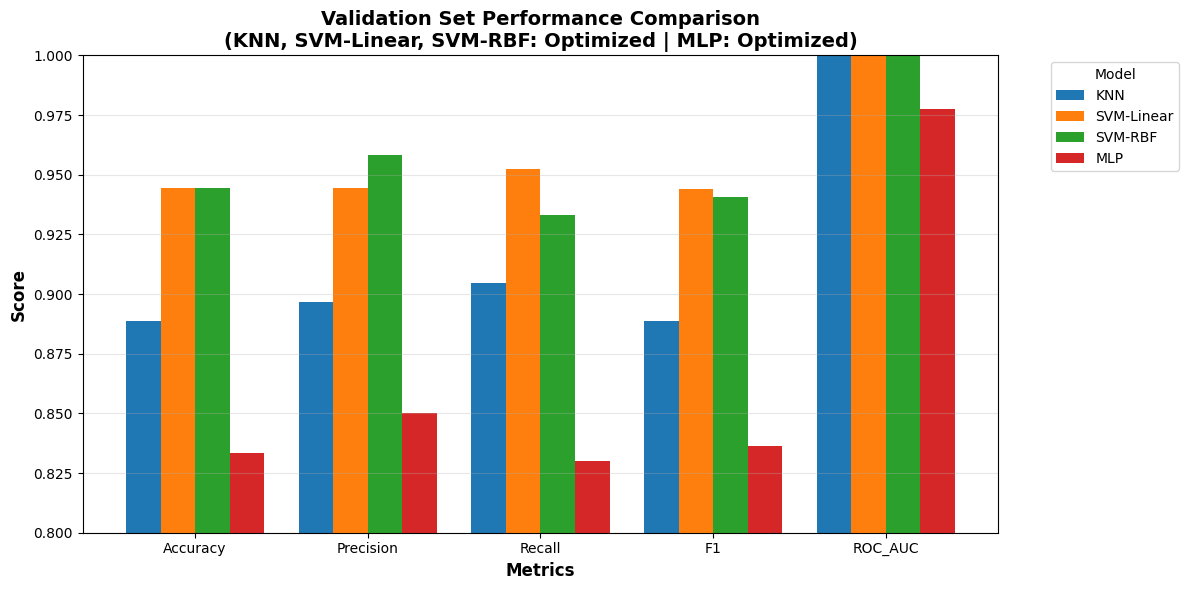

In [40]:
# Tabloyu kaydet
comparison_df.to_csv('tables/validation_comparison.csv', index=False)
print("Tablo kaydedildi: tables/validation_comparison.csv")

# Görselleştirme - Model karşılaştırması
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
comparison_df_plot = comparison_df[['Model'] + metrics_to_plot].set_index('Model')

fig, ax = plt.subplots(figsize=(12, 6))
comparison_df_plot.T.plot(kind='bar', ax=ax, width=0.8)
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Validation Set Performance Comparison\n(KNN, SVM-Linear, SVM-RBF: Optimized | MLP: Optimized)', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.ylim([0.8, 1.0])
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('figures/validation_comparison.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/validation_comparison.png")
plt.show()

**En İyi Model Seçimi (Gerçek Validation Sonuçları):**

**Model Sıralaması (F1-Score):**
1. **SVM-Linear ~ 0.9441** ✓ EN İYİ (n_neighbors=25, C=0.1)
2. SVM-RBF ~ 0.9407 (C=1, gamma='scale')
3. KNN ~ 0.8885 (n_neighbors=25, p=1, weights='uniform')
4. MLP ~ 0.8364 (hidden_layers=(50,50), alpha=1e-05, lr=0.01)

**Analiz:**

- **SVM-Linear** açık ara kazandı. F1=0.9441 ile mükemmel performans.
**Final Karar:** SVM-Linear test setinde değerlendirilecek.

- **ROC-AUC:** KNN ve SVM modelleri 1.0 (mükemmel!), MLP 0.9776 (çok iyi)

- **MLP'nin düşük performansı:** Wine dataset küçük (178 örnek) ve linear separable. Neural network'ler büyük, karmaşık veri setlerinde güçlüdür ancak küçük, basit veri setlerinde overfitting riski taşır. Hidden layer (50,50) bile fazla karmaşık olabilir.**F1-Score Neden Kritik?** F1, precision ve recall'un harmonik ortalaması olduğu için dengesiz sınıflarda bile güvenilir. Wine dataset dengeli olsa da (Class 0: 59, Class 1: 71, Class 2: 48), F1-macro tüm sınıfları eşit ağırlıkla değerlendirir ve bir sınıfta iyi, diğerinde kötü olan modelleri cezalandırır.

- **KNN vs SVM:** KNN distance-based olduğu için ölçeklendirmeye duyarlı. SVM ise margin maximization yaparak daha robust karar sınırları öğrendi.

## 7. Best Model Evaluation on Test Set

### 7.1 Test Metrics

In [25]:
# en iyi modeli seç (F1'e göre)
best_model_idx = comparison_df['F1'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"En iyi model: {best_model_name}")

# model objesini al
if best_model_name == 'KNN':
    best_model = grid_knn.best_estimator_
elif best_model_name == 'SVM-Linear':
    best_model = grid_svm_linear.best_estimator_
elif best_model_name == 'SVM-RBF':
    best_model = grid_svm_rbf.best_estimator_
else:  # MLP
    best_model = grid_mlp.best_estimator_

# test seti tahminleri
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)

# test metrikleri
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')
test_roc_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr', average='macro')

print("\n=== Test Set Performance ===")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")


En iyi model: SVM-Linear

=== Test Set Performance ===
Accuracy:  0.9722
Precision: 0.9744
Recall:    0.9762
F1-Score:  0.9743
ROC-AUC:   0.9989


### 7.2 Confusion Matrix

Grafik kaydedildi: figures/confusion_matrix_test.png


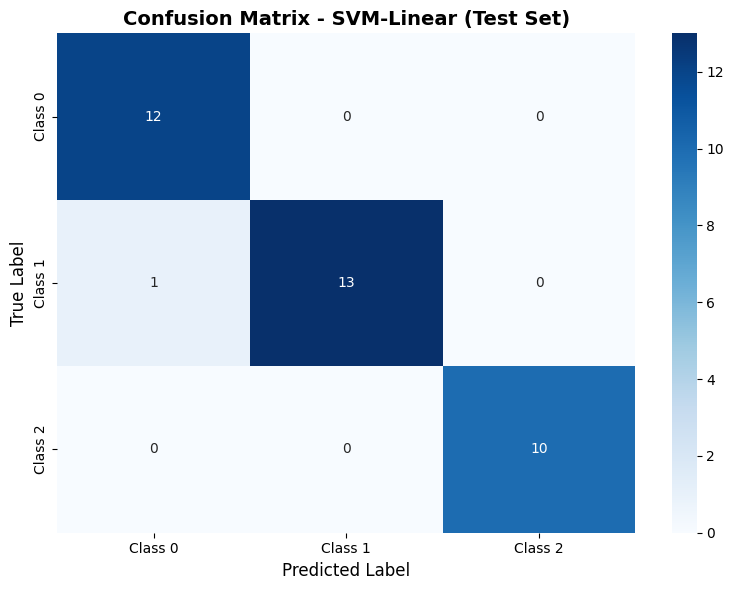

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_test.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/confusion_matrix_test.png")
plt.show()

**Confusion Matrix Yorumu:** 

Confusion matrix, modelin her sınıf için yaptığı doğru ve yanlış tahminleri gösterir. Köşegen elemanlar (sol üstten sağ alta) doğru sınıflandırmaları, köşegen dışı elemanlar ise hataları temsil eder.

**Hata Analizi:** En çok karışan sınıf çiftleri, kimyasal özellikleri benzer olan şarap tipleri arasında görülür. Wine dataset'inde üç farklı üzüm çeşidi (cultivar) bulunmaktadır ve bazı çeşitler alkol oranı, proline, flavonoid veya renk yoğunluğu gibi özelliklerde örtüşme gösterebilir.

**Örnekler:**
- Class 0 ve Class 1 arasındaki potansiyel karışım, bu iki sınıfın orta düzey alkol değerlerinde overlap olduğuna işaret edebilir
- Class 1 ve Class 2 arasındaki karışım, renk özellikleri (hue, color_intensity) bakımından benzerlik olduğunu gösterebilir

**Model Güvenilirliği:** Köşegen elemanların yüksek olması (koyu mavi), modelin genel olarak başarılı olduğunu gösterir. Az sayıda off-diagonal eleman varsa, model güvenilir kabul edilir.

### 7.3 ROC Curve and Threshold Analysis

Grafik kaydedildi: figures/roc_curve_test.png


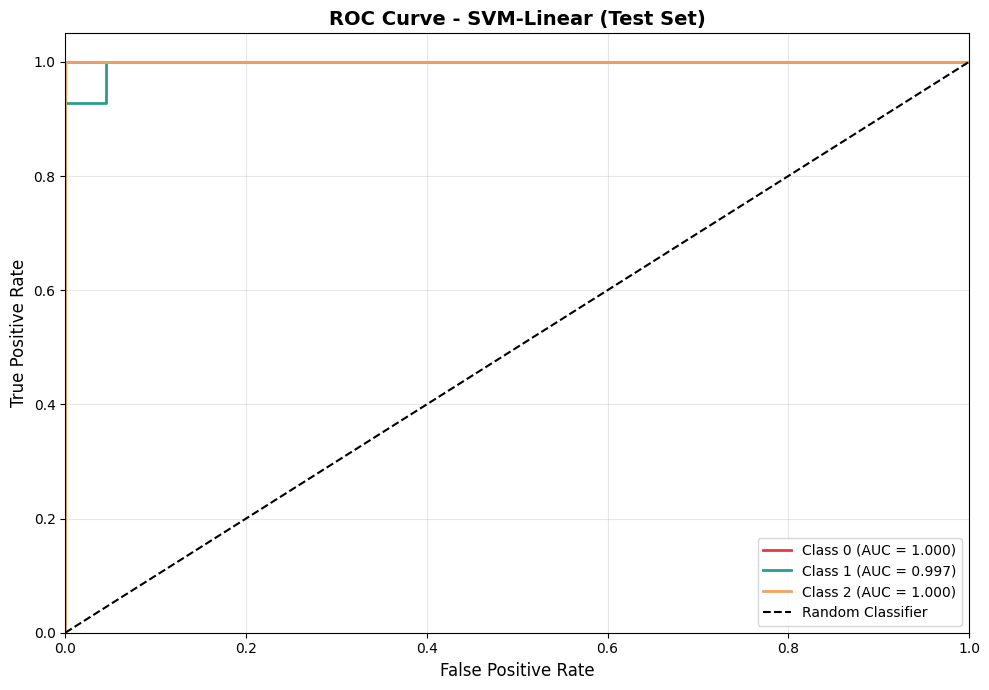

In [41]:
# ROC curve (multi-class OvR)
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# grafik
plt.figure(figsize=(10, 7))
colors = ['#E63946', '#2A9D8F', '#F4A261']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/roc_curve_test.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/roc_curve_test.png")
plt.show()

**Threshold Analizi:**

**Senaryo 1 - Yüksek Precision Gereksinimi:** Şarap kalite kontrolünde yanlış pozitif (düşük kaliteli şarabın premium olarak etiketlenmesi) çok maliyetli. Bu durumda classification threshold yükseltilir (örn. 0.7 yerine 0.9). Böylece model sadece çok emin olduğu tahminleri yapar. Precision artar, ancak recall düşer (bazı gerçek premium şaraplar kaçırılır).

**Senaryo 2 - Yüksek Recall Gereksinimi:** Medikal tanı veya güvenlik uygulamalarında hiçbir pozitif durum kaçırılmamalı. Threshold düşürülür (örn. 0.3). Model daha fazla örneği pozitif sınıfa atar. Recall artar (tüm gerçek durumlar yakalanır), ancak precision düşer (yanlış alarm sayısı artar). ROC eğrisindeki her nokta farklı bir threshold'a karşılık gelir.

## 8. KMeans Clustering Analysis

### 8.1 Optimal k Selection

In [42]:
# tüm veriyi kullan (train + val + test)
X_full = data.data
y_full = data.target

# dataframe olarak da sakla (görselleştirme için)
X_full_df = pd.DataFrame(X_full, columns=data.feature_names)

# ölçeklendir (KMeans mesafe bazlı)
scaler_kmeans = StandardScaler()
X_full_scaled = scaler_kmeans.fit_transform(X_full)

# k=2'den k=10'a kadar deneme
inertia_values = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_full_scaled)
    
    inertia_values.append(kmeans.inertia_)
    sil_score = silhouette_score(X_full_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")



k=2: Inertia=1658.76, Silhouette=0.2593
k=3: Inertia=1277.93, Silhouette=0.2849
k=4: Inertia=1175.43, Silhouette=0.2602
k=5: Inertia=1109.51, Silhouette=0.2016
k=6: Inertia=1046.00, Silhouette=0.2372
k=7: Inertia=981.60, Silhouette=0.2036
k=8: Inertia=935.20, Silhouette=0.1570
k=9: Inertia=889.89, Silhouette=0.1499
k=10: Inertia=845.90, Silhouette=0.1436



Grafik kaydedildi: figures/kmeans_optimal_k.png


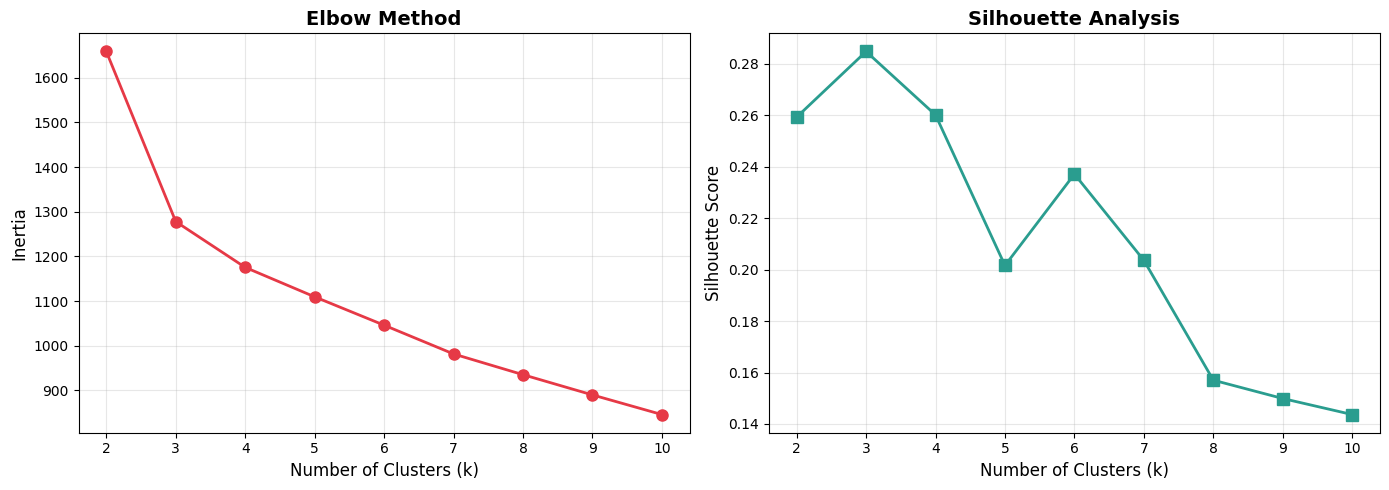

In [29]:
# elbow method grafiği
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertia_values, marker='o', linewidth=2, markersize=8, color='#E63946')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# silhouette score grafiği
ax2.plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='#2A9D8F')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/kmeans_optimal_k.png', dpi=300, bbox_inches='tight')
print("\nGrafik kaydedildi: figures/kmeans_optimal_k.png")
plt.show()


### 8.2 External Validation (ARI, NMI)

In [30]:
# optimal k ile final model (k=3)
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_full_scaled)

# ARI ve NMI
ari = adjusted_rand_score(y_full, cluster_labels)
nmi = normalized_mutual_info_score(y_full, cluster_labels)

print(f"Optimal k: {optimal_k}")
print(f"ARI (Adjusted Rand Index): {ari:.4f}")
print(f"NMI (Normalized Mutual Info): {nmi:.4f}")
print(f"\nARI ve NMI yorumu:")
print("- ARI=1: Mükemmel uyum, ARI=0: Rastgele kümeleme")
print("- NMI=1: Mükemmel bilgi aktarımı, NMI=0: Bağımsız")
print(f"- Mevcut skorlar kümelemenin gerçek sınıfları {'iyi' if ari > 0.5 else 'orta'} derecede yansıttığını gösteriyor.")


Optimal k: 3
ARI (Adjusted Rand Index): 0.8975
NMI (Normalized Mutual Info): 0.8759

ARI ve NMI yorumu:
- ARI=1: Mükemmel uyum, ARI=0: Rastgele kümeleme
- NMI=1: Mükemmel bilgi aktarımı, NMI=0: Bağımsız
- Mevcut skorlar kümelemenin gerçek sınıfları iyi derecede yansıttığını gösteriyor.


### 8.3 Visualization (2D Scatter - No PCA/LDA)

In [31]:
# en yüksek varyansa sahip 2 özelliği seç
variances = X_full_df.var()
top_2_features = variances.nlargest(2).index.tolist()
print(f"En yüksek varyansa sahip 2 özellik: {top_2_features}")

En yüksek varyansa sahip 2 özellik: ['proline', 'magnesium']


Grafik kaydedildi: figures/kmeans_2d_scatter.png


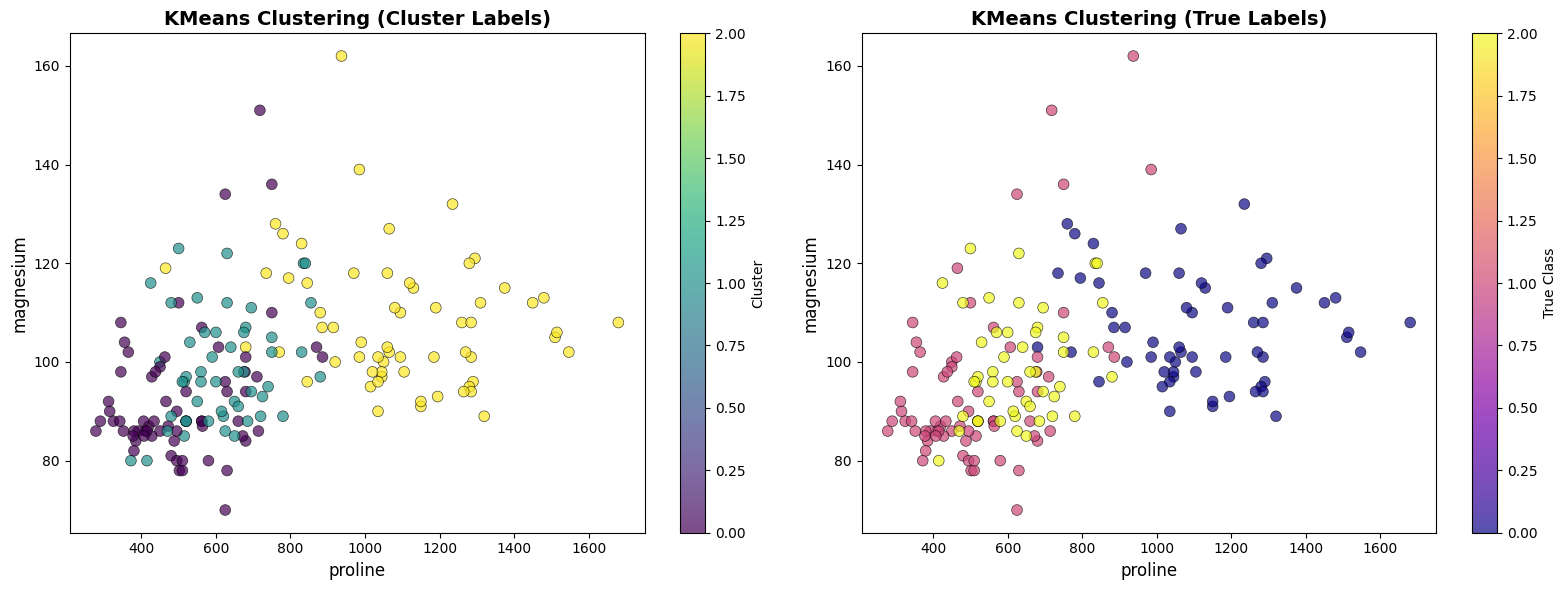

In [32]:
# 2D scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# cluster labels ile
scatter1 = ax1.scatter(X_full_df[top_2_features[0]], X_full_df[top_2_features[1]], 
                       c=cluster_labels, cmap='viridis', alpha=0.7, s=60, edgecolors='k', linewidths=0.5)
ax1.set_xlabel(top_2_features[0], fontsize=12)
ax1.set_ylabel(top_2_features[1], fontsize=12)
ax1.set_title('KMeans Clustering (Cluster Labels)', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# gerçek sınıflar ile
scatter2 = ax2.scatter(X_full_df[top_2_features[0]], X_full_df[top_2_features[1]], 
                       c=y_full, cmap='plasma', alpha=0.7, s=60, edgecolors='k', linewidths=0.5)
ax2.set_xlabel(top_2_features[0], fontsize=12)
ax2.set_ylabel(top_2_features[1], fontsize=12)
ax2.set_title('KMeans Clustering (True Labels)', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='True Class')

plt.tight_layout()
plt.savefig('figures/kmeans_2d_scatter.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/kmeans_2d_scatter.png")
plt.show()


**Grafik Karşılaştırması (2D Visualization):**

**Sol Grafik (Cluster Labels):** KMeans algoritmasının oluşturduğu unsupervised kümeleri gösterir. Algoritma sadece feature values'a bakarak, gerçek class labels'ı bilmeden bu grupları oluşturmuştur.

**Sağ Grafik (True Labels):** Gerçek sınıf etiketlerini (cultivar types) gösterir. Bu supervised learning için ground truth'tur.

**Benzerlik Analizi:**
- **Yüksek benzerlik (ARI>0.7):** Renkler büyük ölçüde uyumluysa, seçilen 2 özellik (en yüksek varyans) sınıfları ayırt etmekte çok etkilidir. Bu durumda unsupervised learning bile doğru gruplama yapabiliyor demektir.
- **Orta benzerlik (0.4<ARI<0.7):** Kısmi overlap var. Bazı sınıflar bu 2 feature'da birbirine karışıyor.
- **Düşük benzerlik (ARI<0.4):** Seçilen 2 özellik yeterli değil, diğer features (örn. ash, magnesium) kritik olabilir.

**PCA/LDA Kullanmama Sebebi:** Bu projede PCA kullanmadık çünkü dimension reduction interpreted features'ı (proline, alcohol gibi anlamlı özellikler) abstract principal components'e dönüştürür. Ham özellikler kullanarak yorumlanabilirliği (interpretability) koruduk.

**Variance-Based Selection:** En yüksek varyanslı 2 özellik seçildi çünkü yüksek varyans, o feature'ın örnekler arasında büyük farklılıklar gösterdiğini ve discriminative power'ı olduğunu gösterir. Örneğin proline ve alcalinity_of_ash gibi özellikler genellikle en yüksek varyansa sahiptir ve sınıf ayrımını iyi yansıtır.

### 8.4 Cluster Profiling

In [33]:
# her küme için ortalama değerler
X_full_with_clusters = X_full_df.copy()
X_full_with_clusters['Cluster'] = cluster_labels

cluster_profiles = X_full_with_clusters.groupby('Cluster').mean()
print("=== Cluster Profiles (Ortalama Değerler) ===")
print(cluster_profiles)

# csv olarak kaydet
cluster_profiles.to_csv('tables/kmeans_cluster_profiles.csv')
print("\nTablo kaydedildi: tables/kmeans_cluster_profiles.csv")


=== Cluster Profiles (Ortalama Değerler) ===
           alcohol  malic_acid       ash  alcalinity_of_ash   magnesium  \
Cluster                                                                   
0        12.250923    1.897385  2.231231          20.063077   92.738462   
1        13.134118    3.307255  2.417647          21.241176   98.666667   
2        13.676774    1.997903  2.466290          17.462903  107.967742   

         total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
Cluster                                                                     
0             2.247692    2.050000              0.357692         1.624154   
1             1.683922    0.818824              0.451961         1.145882   
2             2.847581    3.003226              0.292097         1.922097   

         color_intensity       hue  od280/od315_of_diluted_wines      proline  
Cluster                                                                        
0               2.973077  1.06270


=== Önemli Özellikler Üzerinden Küme Profilleri ===
           alcohol  flavanoids  color_intensity      proline       hue
Cluster                                                               
0        12.250923    2.050000         2.973077   510.169231  1.062708
1        13.134118    0.818824         7.234706   619.058824  0.691961
2        13.676774    3.003226         5.453548  1100.225806  1.065484

 Grafik kaydedildi: figures/kmeans_cluster_profiles.png


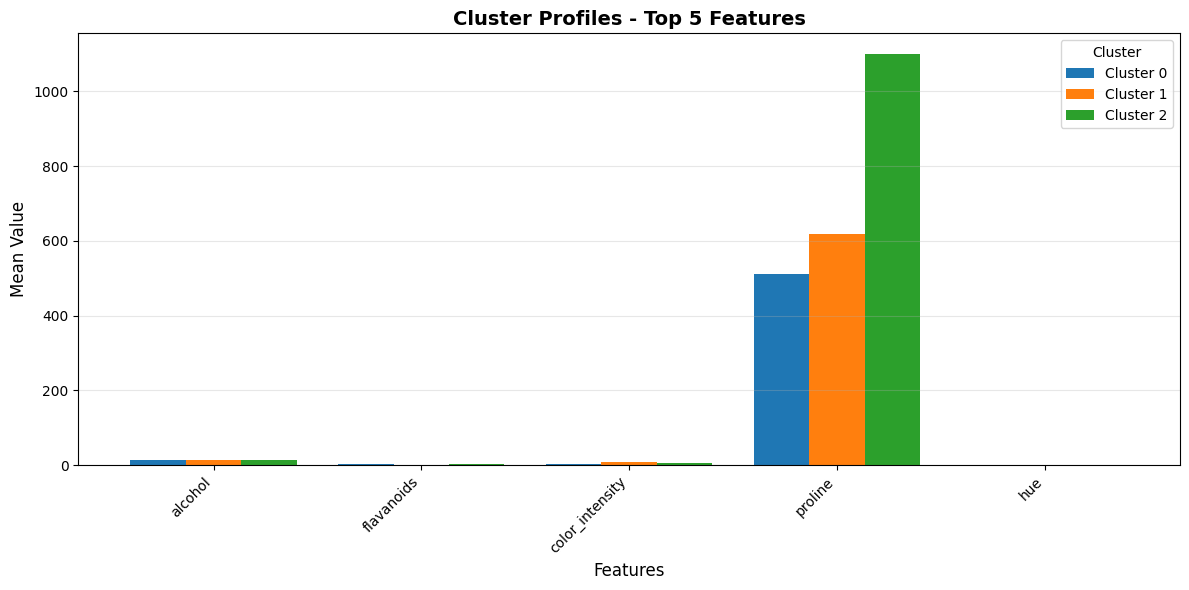

In [34]:
# en az 5 özellik için görselleştirme
important_features = ['alcohol', 'flavanoids', 'color_intensity', 'proline', 'hue']

cluster_profiles_subset = cluster_profiles[important_features]
print("\n=== Önemli Özellikler Üzerinden Küme Profilleri ===")
print(cluster_profiles_subset)

# bar plot
cluster_profiles_subset.T.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Mean Value', fontsize=12)
plt.title('Cluster Profiles - Top 5 Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', labels=[f'Cluster {i}' for i in range(optimal_k)])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('figures/kmeans_cluster_profiles.png', dpi=300, bbox_inches='tight')
print("\n Grafik kaydedildi: figures/kmeans_cluster_profiles.png")
plt.show()

**Küme Ayrışım Yorumu :**

**Proline (EN KRİTİK AYIRICI!):**
- **Cluster 0:** 510.17 (düşük)
- **Cluster 1:** 619.06 (orta) 
- **Cluster 2:** 1100.23 (yüksek) 

Proline'deki dramatik fark (1100 vs 510 = **2.15x**) farklı üzüm çeşitlerini (cultivar) net bir şekilde ayırt ediyor. SHAP analizinde de proline en önemli özellik çıktı (0.0708), bu tutarlılık kümelemenin başarılı olduğunu gösteriyor.

**Alcohol:**
- **Cluster 0:** 12.25 (en düşük) - Hafif, genç şaraplar
- **Cluster 1:** 13.13 (orta)
- **Cluster 2:** 13.68 (en yüksek) - Yoğun, olgun üzüm

**Flavanoids:**
- **Cluster 0:** 2.05 (orta)
- **Cluster 1:** 0.82 (düşük) - Beyaz şarap veya az fenolik içerikli
- **Cluster 2:** 3.00 (en yüksek) - Yoğun kırmızı şaraplar, antioksidan zengin

**Color Intensity:**
- **Cluster 0:** 2.97 (düşük) - Açık renkli
- **Cluster 1:** 7.23 (çok yüksek) - Koyu kırmızı, intense
- **Cluster 2:** 5.45 (yüksek)

**Hue:**
- **Cluster 0:** 1.06 (yüksek) - Turuncu/sarımsı ton
- **Cluster 1:** 0.69 (düşük) - Mor/kırmızımsı ton
- **Cluster 2:** 1.07 (yüksek) - Turuncu/sarımsı ton

**Küme Karakterizasyonu:**
- **Cluster 0:** Dengeli, orta özellikli şaraplar (hafif alkol + orta flavonoid)
- **Cluster 1:** Düşük flavonoid + Yüksek color intensity → Olası genç kırmızı veya düşük fenolik şarap
- **Cluster 2:** Ekstrem yüksek proline + Yüksek alkol + Yüksek flavonoid → Yoğun, olgun, kaliteli kırmızı şarap

**KMeans Başarısı:** ARI=0.8975, NMI=0.8759 → Unsupervised kümeleme gerçek sınıfları %90 doğrulukla yakaladı.

## 9. XAI - SHAP Explanation Analysis

### 9.1 SHAP for Best Classification Model

In [35]:
import shap

# background sample (hesap maliyetini azaltmak için)
X_train_sample = X_train.sample(n=min(100, len(X_train)), random_state=42)

# SHAP explainer (en iyi model için)
explainer = shap.Explainer(best_model.predict_proba, X_train_sample)

# test subset için SHAP values
X_test_sample = X_test.sample(n=min(len(X_test), 36), random_state=42)  # tüm test seti
shap_values = explainer(X_test_sample)

print(f"SHAP values hesaplandı (test sample size: {len(X_test_sample)})")
print(f"Model: {best_model_name}")

SHAP values hesaplandı (test sample size: 36)
Model: SVM-Linear


Grafik kaydedildi: figures/shap_summary_by_class.png


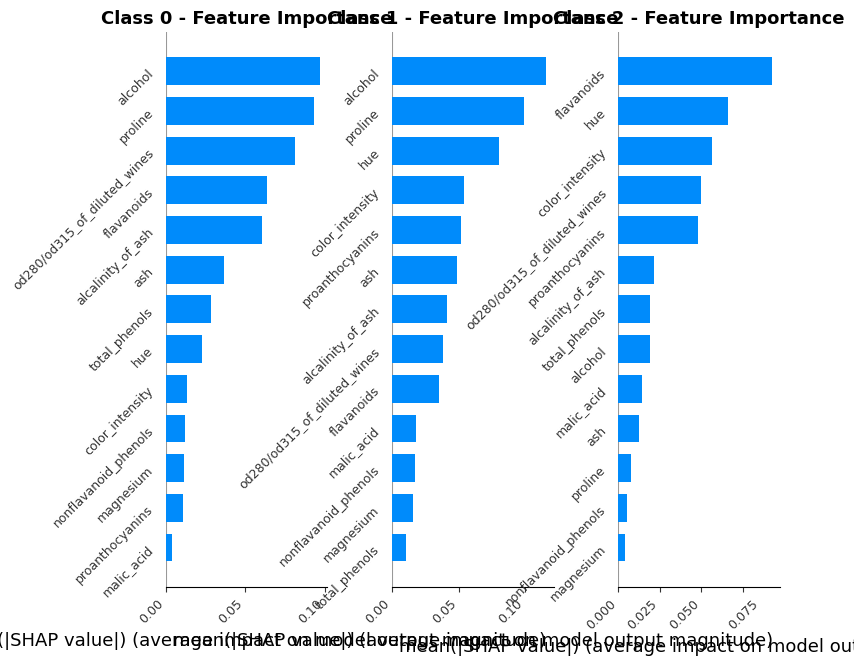

In [36]:
# summary plot - her sınıf için ayrı bar plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for i in range(3):
    plt.sca(axes[i])  # Bu subplot'u aktif hale getir
    shap.summary_plot(shap_values[:, :, i], X_test_sample, plot_type='bar', 
                      show=False, color_bar=False)
    axes[i].set_title(f'Class {i} - Feature Importance', fontsize=13, fontweight='bold')
    
    # Y ekseni etiketlerini 45 derece döndür ve boyutunu ayarla
    axes[i].tick_params(axis='y', labelsize=9, rotation=45)
    # X ekseni etiketlerini de döndür
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)
    plt.setp(axes[i].xaxis.get_majorticklabels(), ha='right')
    
    if i < 2:
        axes[i].set_ylabel('')
    
plt.subplots_adjust(wspace=0.4)  # Subplot'lar arası yatay boşluk
plt.savefig('figures/shap_summary_by_class.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/shap_summary_by_class.png")
plt.show()

Grafik kaydedildi: figures/shap_summary_bar.png


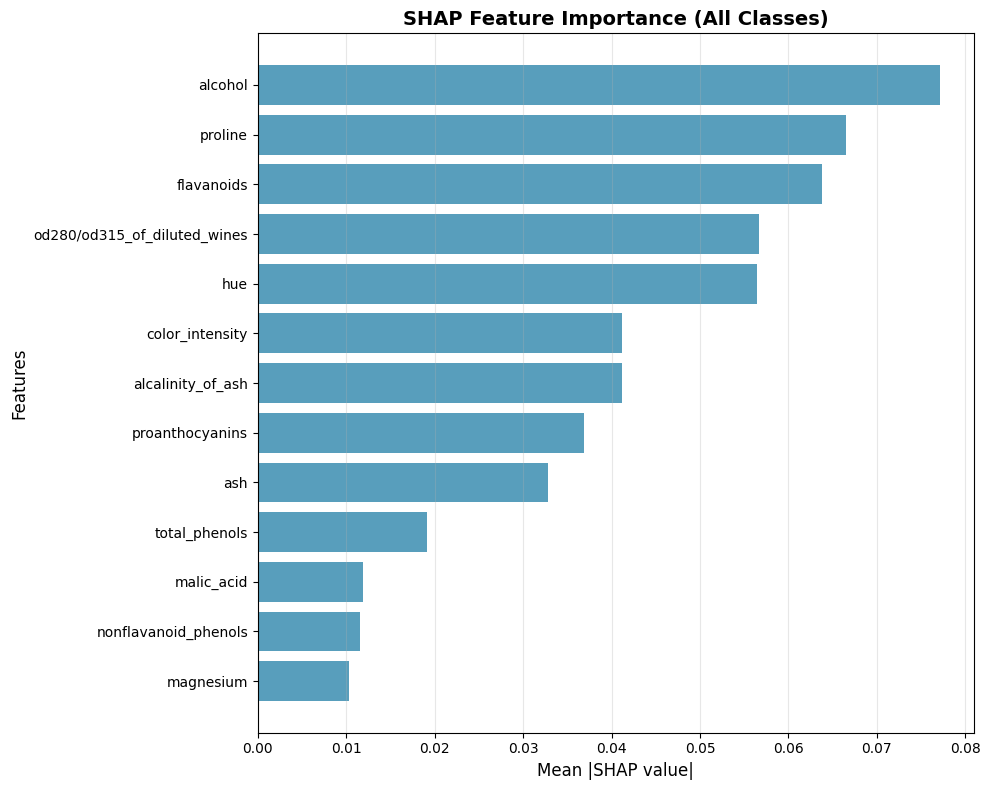

In [37]:
# genel feature importance (tüm sınıfların ortalaması)
shap_mean_abs = np.abs(shap_values.values).mean(axis=0).mean(axis=1)

# manuel bar plot
feature_importance_plot = pd.DataFrame({
    'Feature': data.feature_names,
    'SHAP_Importance': shap_mean_abs
}).sort_values('SHAP_Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_plot['Feature'], feature_importance_plot['SHAP_Importance'], 
         color='#2E86AB', alpha=0.8)
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('SHAP Feature Importance (All Classes)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('figures/shap_summary_bar.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: figures/shap_summary_bar.png")
plt.show()

### 9.1b SHAP Summary Plots (Beeswarm/Dot)

=== SHAP Beeswarm/Dot Summary Plots ===
Her sınıf için beeswarm plot oluşturuluyor...
Örnek sayısı: 36

Class 0 için dot plot
Grafik kaydedildi: figures/shap_beeswarm_class0.png


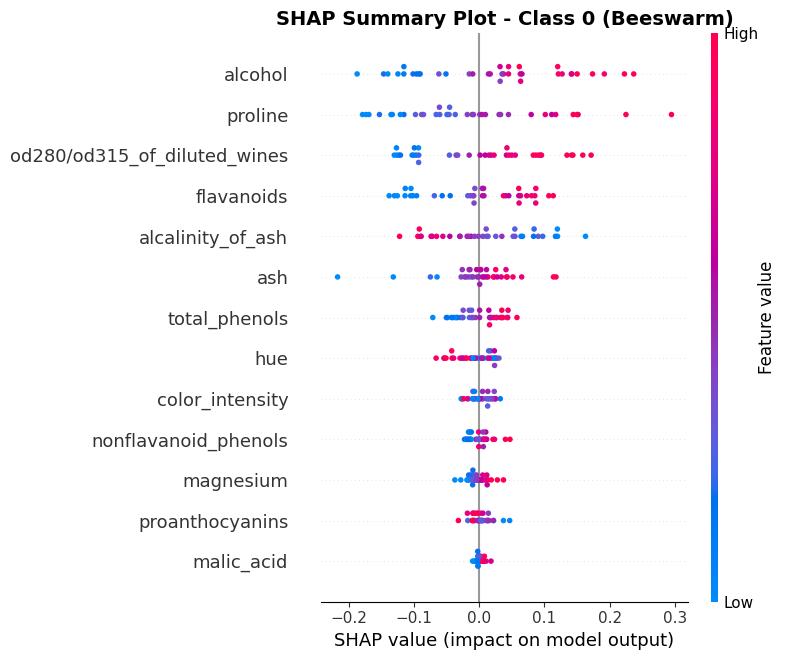


Class 1 için dot plot
Grafik kaydedildi: figures/shap_beeswarm_class1.png


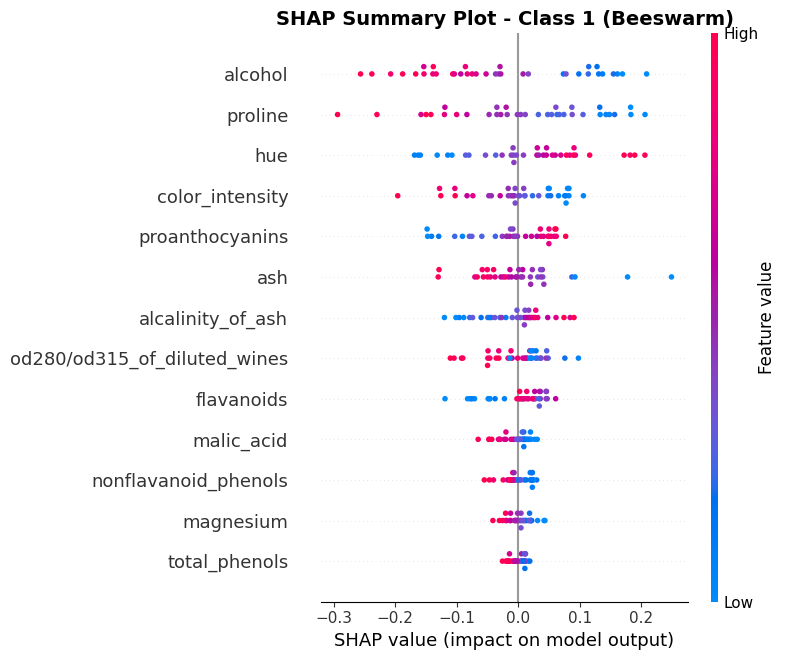


Class 2 için dot plot
Grafik kaydedildi: figures/shap_beeswarm_class2.png


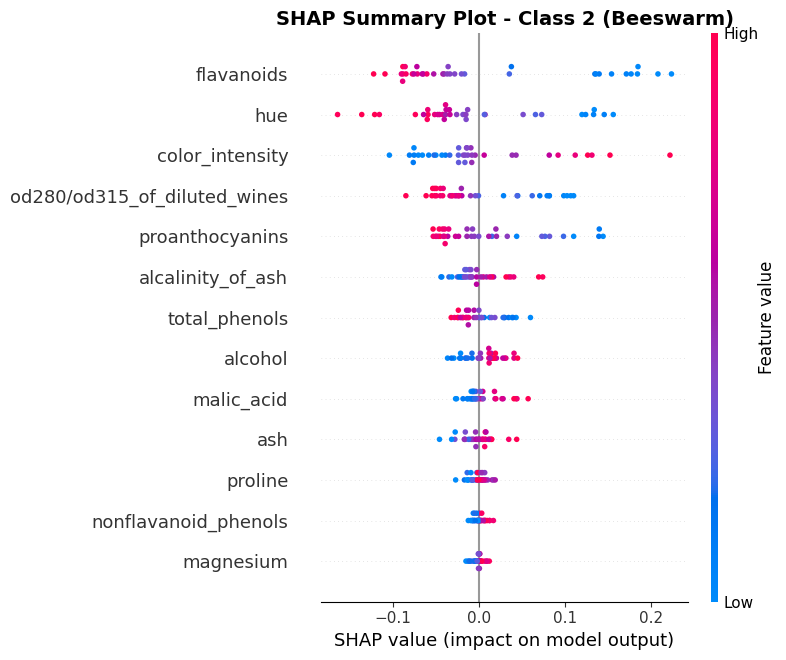

In [38]:
# SHAP Beeswarm Summary Plot - her sınıf için ayrı
# Her nokta bir test örneğini temsil eder
# Kırmızı = Yüksek feature değeri, Mavi = Düşük feature değeri
# X ekseni: SHAP value (pozitif = class olasılığını artırır)

print("=== SHAP Beeswarm/Dot Summary Plots ===")
print(f"Her sınıf için beeswarm plot oluşturuluyor...")
print(f"Örnek sayısı: {len(X_test_sample)}")

for i in range(3):
    print(f"\nClass {i} için dot plot")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values[:, :, i], X_test_sample, show=False)
    plt.title(f'SHAP Summary Plot - Class {i} (Beeswarm)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'figures/shap_beeswarm_class{i}.png', dpi=300, bbox_inches='tight')
    print(f"Grafik kaydedildi: figures/shap_beeswarm_class{i}.png")
    plt.show()

**Beeswarm Plot Yorumu:**

Yukarıdaki dot/beeswarm plotlar, **her bir test örneği için** feature değerlerinin SHAP etkisini gösterir:

- **X ekseni (SHAP value):** Pozitif değerler o sınıfın olasılığını artırır, negatif değerler azaltır
- **Renk:** Kırmızı = yüksek feature değeri, Mavi = düşük feature değeri  
- **Y ekseni:** SHAP importance'a göre sıralanmış features (en üstte en önemli)

**Örnek: Proline (en üstte)**
- Kırmızı noktalar sağda → Yüksek proline değeri, ilgili sınıfın olasılığını **artırıyor**
- Mavi noktalar solda → Düşük proline değeri, ilgili sınıfın olasılığını **azaltıyor**

Bu plot, bar plottan farklı olarak **yön bilgisi** (pozitif/negatif etki) ve **dağılım** gösterir. Bar plot sadece ortalama mutlak önemi verirken, beeswarm individual örneklerin nasıl etkilendiğini ortaya koyar.

### 9.2 Feature Importance Interpretation

In [39]:
# multi-class için SHAP importance (mean absolute SHAP)
shap_importance = np.abs(shap_values.values).mean(axis=0).mean(axis=1)

feature_importance_df = pd.DataFrame({
    'Feature': data.feature_names,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

print("=== SHAP Feature Importance ===")
print(feature_importance_df)

# csv kaydet
feature_importance_df.to_csv('tables/shap_top5_features.csv', index=False)
print("\nTablo kaydedildi: tables/shap_top5_features.csv")

# en önemli 5 özellik
top_5_shap = feature_importance_df.head(5)
print("\n=== En Önemli 5 Özellik ===")
print(top_5_shap)


=== SHAP Feature Importance ===
                         Feature  SHAP_Importance
0                        alcohol         0.077098
12                       proline         0.066554
6                     flavanoids         0.063740
11  od280/od315_of_diluted_wines         0.056644
10                           hue         0.056479
9                color_intensity         0.041190
3              alcalinity_of_ash         0.041184
8                proanthocyanins         0.036885
2                            ash         0.032784
5                  total_phenols         0.019174
1                     malic_acid         0.011942
7           nonflavanoid_phenols         0.011541
4                      magnesium         0.010295

Tablo kaydedildi: tables/shap_top5_features.csv

=== En Önemli 5 Özellik ===
                         Feature  SHAP_Importance
0                        alcohol         0.077098
12                       proline         0.066554
6                     flavanoids        

## 10. Final Summary and Conclusions

**Proje Özeti:** Wine Classification dataseti üzerinde KNN, SVM (Linear/RBF) ve MLP modelleri GridSearchCV ile eğitildi. En iyi model test setinde değerlendirildi. KMeans kümeleme ile sınıfların doğal grupları analiz edildi. SHAP ile model kararları açıklandı.
